# imports

In [1]:
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# impute.imputer
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # pd.get_dummies
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA
# stats : R module
from scipy.stats import skew, kurtosis

# estimators ---------------------------------------
# estimators.classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # classifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV # regressor 응용
# estimators.regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
# --------------------------------------------------

# neural network -----------------------------------
import tensorflow as tf
import keras
# --------------------------------------------------

# ensemble -----------------------------------------
# ensemble.bagging
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# ensemble.boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
# ensemble.boosting & bagging
from xgboost import XGBRFClassifier, XGBRFRegressor
# ensemble.voting
from sklearn.ensemble import VotingClassifier, VotingRegressor
# --------------------------------------------------

# metrics ------------------------------------------
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# --------------------------------------------------

# model_selection ----------------------------------
# model_selection.splitter
from sklearn.model_selection import train_test_split
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV
# --------------------------------------------------

# optuna -------------------------------------------
import optuna
# --------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm

from IPython.core.display import display, HTML
# display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

plt.rcParams['font.family'] = 'Malgun Gothic'

# read

In [3]:
cus   = pd.read_csv('./data/cus_info.csv')
iem   = pd.read_csv('./data/iem_info_20210902.csv')
hist  = pd.read_csv('./data/stk_bnc_hist.csv')
train = pd.read_csv('./data/stk_hld_train.csv')
test  = pd.read_csv('./data/stk_hld_test.csv')
sub   = pd.read_csv('./data/sample_submission.csv')
pct   = pd.read_csv('./sub/dacon_baseline_7.csv')

# EDA

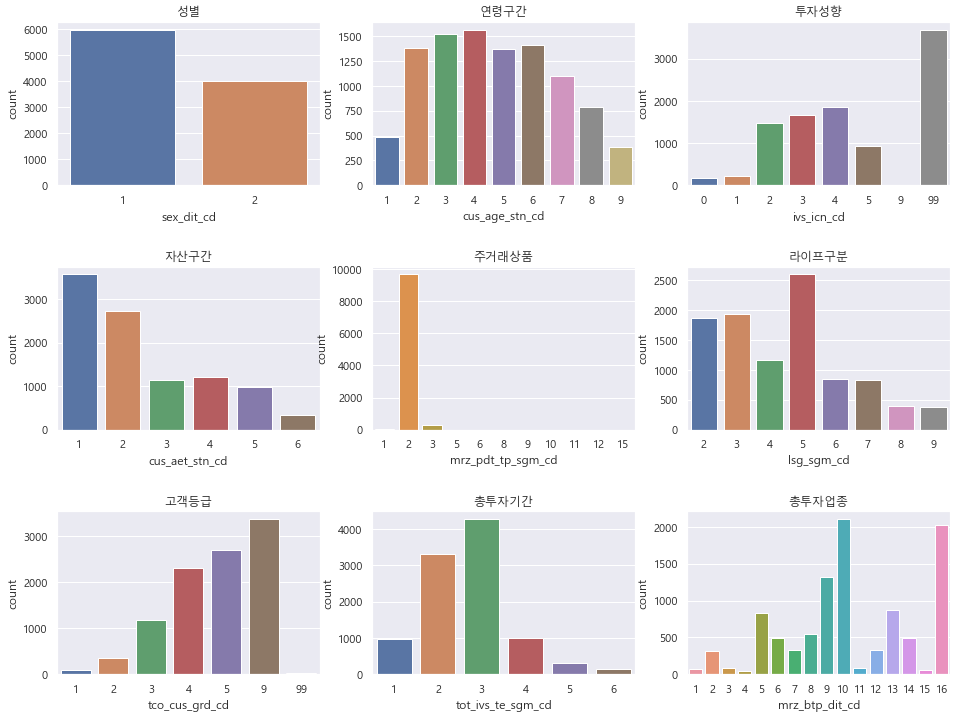

In [4]:
cus_cols = ['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd']
cols     = ['성별', '연령구간', '투자성향', '자산구간', '주거래상품', '라이프구분', '고객등급', '총투자기간', '총투자업종']    

fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols):
    r = i // 3
    c = i % 3
    sns.countplot(col, data=cus, ax=ax[r, c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

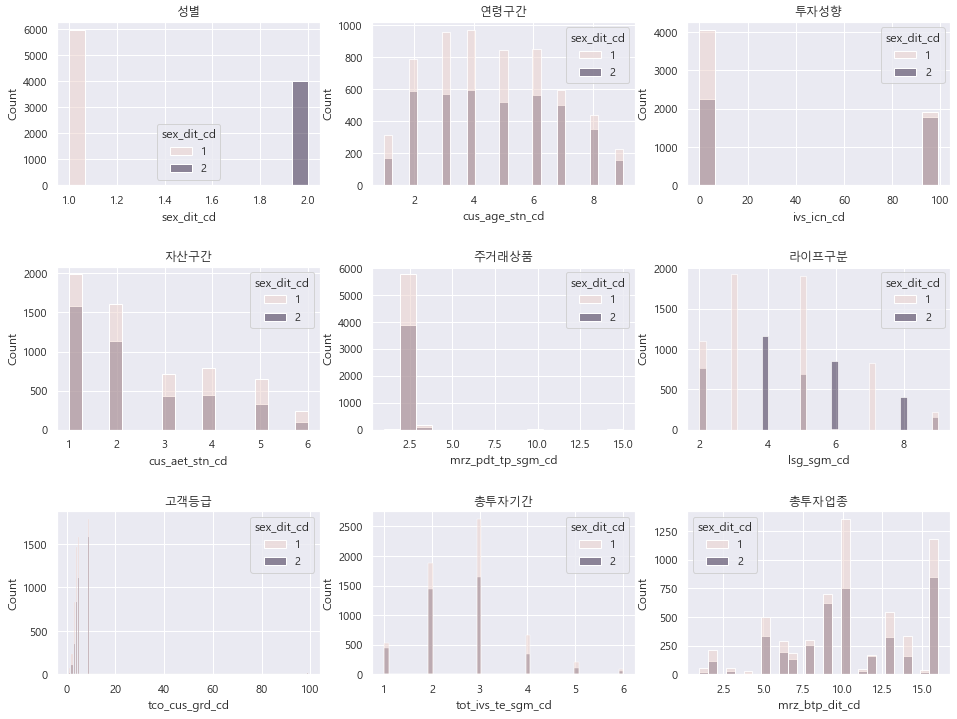

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols) :
    r = i // 3
    c = i % 3
    sns.histplot(data=cus, x=col, hue='sex_dit_cd', ax=ax[r ,c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# feature engineering

## cus.ivs_icn_cd : 투자성향

In [6]:
# 투자성향 미정의(99) 비율 0.3687 : drop
print(cus[cus['ivs_icn_cd'] == 99].shape[0] / cus.shape[0])
cus.drop('ivs_icn_cd', axis=1, inplace=True)

0.3687


## cus.lsg_sgm_cd : life stage

In [7]:
# 연령과 성별 변수 포함 : drop
cus.drop('lsg_sgm_cd', axis=1, inplace=True)

## cus.tco_cus_grd_cd : 고객등급

In [8]:
# 서비스 등급 결측치(99)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 1)] = 3 # 1억 이상, 3억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 2)] = 3 # 1억 이상, 3억 미만

# 서비스 등급 미정의(9)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 1)] = 9 # 1천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 2)] = 5 # 1천 이상, 3천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 3)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 4)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 5)] = 3 # 1억 이상, 3억 미만

# 이외의 서비스 등급 미정의(9)는 고객등급 6으로 설정
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9)] = 6

<AxesSubplot:>

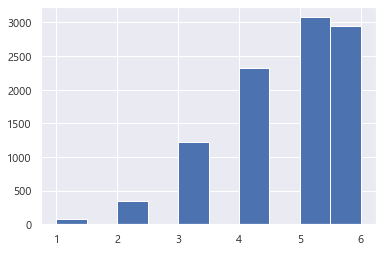

In [9]:
cus['tco_cus_grd_cd'].hist()

## iem.mkt_pr_tal_scl_tp_cd : 시총규모

In [10]:
# 기타(99) -> 3
iem['mkt_pr_tal_scl_tp_cd'][iem['mkt_pr_tal_scl_tp_cd'] == 99] = 3

## iem.stk_dit_cd : 시장구분

In [11]:
# 기타(99) -> 3
iem['stk_dit_cd'][iem['stk_dit_cd'] == 99] = 3

## hist.stk_p : 매매 평균단가

In [12]:
hist['stk_p'] = hist['tot_aet_amt'] / hist['bnc_qty']
hist['stk_p'].fillna(0, inplace=True)

## train.hist_d

In [13]:
# train['hist_d'] = np.trunc(train['hold_d'] * 0.7)
pct

,submit_id,hold_d
0,IDX00001,243.0
1,IDX00002,481.0
2,IDX00003,221.0
3,IDX00004,375.0
4,IDX00005,15.0
...,...,...
70591,IDX70592,37.0
70592,IDX70593,164.0
70593,IDX70594,863.0
70594,IDX70595,18.0


In [14]:
test_pct = pd.merge(test, pct, how='left', on='submit_id')
test_pct['pct'] = test_pct['hist_d'] / test_pct['hold_d_y']
test_pct

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d_x,hold_d_y,pct
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A032640,20200522,153,IDX00001,0,243.0,0.629630
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A160600,20190823,335,IDX00002,0,481.0,0.696466
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A234340,20200611,139,IDX00003,0,221.0,0.628959
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A131760,20200120,236,IDX00004,0,375.0,0.629333
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A293490,20201217,9,IDX00005,0,15.0,0.600000
...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A000810,20201127,23,IDX70592,0,37.0,0.621622
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A005945,20200731,103,IDX70593,0,164.0,0.628049
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A004740,20170704,858,IDX70594,0,863.0,0.994206
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A001630,20201215,11,IDX70595,0,18.0,0.611111


In [15]:
gb_pct = test_pct.groupby('act_id').mean()[['pct']]

In [16]:
gb_pct.mean()

pct    0.631858
dtype: float64

In [17]:
gb_train = pd.merge(train, gb_pct, how='left', on='act_id')

In [18]:
gb_train

,act_id,iem_cd,byn_dt,hold_d,pct
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A006360,20180726,11,0.636878
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A005930,20180131,80,0.636878
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A005070,20180517,5,0.636878
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A003520,20201112,22,0.636878
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A002310,20180905,324,0.636878
...,...,...,...,...,...
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A260660,20180831,1,0.725582
681468,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A271980,20201027,1,0.725582
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A289080,20181121,1,0.725582
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a78555d3d5aa55abe94,A307930,20200214,1,0.725582


In [19]:
gb_train.loc[gb_train[gb_train['pct'].isna()].index, 'pct'] = gb_pct.mean()[0]

In [20]:
gb_train[gb_train['pct'].isna()]

,act_id,iem_cd,byn_dt,hold_d,pct


In [21]:
train = gb_train

In [22]:
train['hist_d'] = np.trunc(train['hold_d'] * train['pct'])

In [23]:
train.drop('pct', axis=1, inplace=True)

# merge

## cus & iem

In [24]:
train_data = pd.merge(train, cus, how='left', on='act_id')
train_data = pd.merge(train_data, iem, how='left', on='iem_cd')

test_data = pd.merge(test, cus, how='left', on='act_id')
test_data = pd.merge(test_data, iem, how='left', on='iem_cd')

## hist

In [25]:
train_data = pd.merge(train_data, hist, how='left', on=['act_id', 'iem_cd'])
train_data = train_data[(train_data['byn_dt'] == train_data['bse_dt'])]

test_data = pd.merge(test_data, hist, how = 'left', on=['act_id', 'iem_cd'])
test_data = test_data[(test_data['byn_dt'] == test_data['bse_dt'])]

In [26]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# encode

In [27]:
le_iem = LabelEncoder()
le_iem.fit(iem['iem_krl_nm'])
train_data['iem_krl_nm'] = le_iem.transform(train_data['iem_krl_nm'])
test_data['iem_krl_nm']  = le_iem.transform(test_data['iem_krl_nm'])

le_act = LabelEncoder()
le_act.fit(cus['act_id'])
train_data['act_id'] = le_act.transform(train_data['act_id'])
test_data ['act_id'] = le_act.transform(test_data['act_id'])

# drop

In [28]:
train_data.drop(['iem_cd', 'byn_dt', 'bse_dt'], axis=1, inplace=True)
test_data.drop(['iem_cd', 'byn_dt', 'bse_dt', 'submit_id', 'hold_d'], axis=1, inplace=True)

In [29]:
train_data

,act_id,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,399,11,7.0,1,9,2,2,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,399,80,50.0,1,9,2,2,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,399,5,3.0,1,9,2,2,5,5,8,2530,12,2,3,786.0,14619600.0,1000.0,18600.0
3,399,22,14.0,1,9,2,2,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,399,324,206.0,1,9,2,2,5,5,8,1696,10,3,3,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,2678,1,0.0,1,4,2,2,4,3,8,1752,10,3,3,199.0,3532250.0,500.0,17750.0
681468,2678,1,0.0,1,4,2,2,4,3,8,2344,8,2,3,488.0,22960400.0,500.0,47050.0
681469,2678,1,0.0,1,4,2,2,4,3,8,521,2,2,3,2210.0,9204650.0,500.0,4165.0
681470,2678,1,0.0,1,4,2,2,4,3,8,2460,2,3,3,285.0,2721750.0,500.0,9550.0


In [30]:
train_data.shape, test_data.shape

((681472, 18), (70596, 17))

# scale

In [31]:
rbs = RobustScaler()

rbs.fit(train_data[test_data.columns])
train_data[test_data.columns] = rbs.transform(train_data[test_data.columns])
test_data[test_data.columns]  = rbs.transform(test_data[test_data.columns])

In [32]:
train_data['hold_d'] = np.log1p(train_data['hold_d'])

# score

In [33]:
train_data

,act_id,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,-0.825979,2.484907,0.625,0.0,1.333333,0.0,0.0,0.5,2.0,-0.666667,-1.096168,-1.500000,-0.5,-2.0,0.917012,4.213264,4500.0,0.908691
1,-0.825979,4.394449,6.000,0.0,1.333333,0.0,0.0,0.5,2.0,-0.666667,-0.185105,-0.166667,-0.5,-2.0,-0.211618,1.586814,4500.0,72.783233
2,-0.825979,1.791759,0.125,0.0,1.333333,0.0,0.0,0.5,2.0,-0.666667,0.660159,0.333333,0.0,0.0,3.041494,5.310557,500.0,0.193463
3,-0.825979,3.135494,1.500,0.0,1.333333,0.0,0.0,0.5,2.0,-0.666667,0.254519,-0.333333,0.0,-2.0,0.029046,-0.164153,0.0,-0.126044
4,-0.825979,5.783825,25.500,0.0,1.333333,0.0,0.0,0.5,2.0,-0.666667,0.057122,0.000000,0.5,0.0,0.539419,2.799188,4500.0,0.949729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,-0.388718,0.693147,-0.250,0.0,-0.333333,0.0,0.0,0.0,0.0,-0.666667,0.097614,0.000000,0.5,0.0,0.605809,1.023105,0.0,0.168548
681468,-0.388718,0.693147,-0.250,0.0,-0.333333,0.0,0.0,0.0,0.0,-0.666667,0.525669,-0.333333,0.0,0.0,1.804979,8.535924,0.0,1.027407
681469,-0.388718,0.693147,-0.250,0.0,-0.333333,0.0,0.0,0.0,0.0,-0.666667,-0.792480,-1.333333,0.0,0.0,8.950207,3.216609,0.0,-0.229664
681470,-0.388718,0.693147,-0.250,0.0,-0.333333,0.0,0.0,0.0,0.0,-0.666667,0.609544,-1.333333,0.5,0.0,0.962656,0.709687,0.0,-0.071816


In [34]:
X_train_data = train_data.drop('hold_d', axis=1)
y_train_data = train_data['hold_d']

In [35]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(X_train_data):
    
    train_x = X_train_data.iloc[train_idx, :]
    train_y = y_train_data[train_idx]
    val_x = X_train_data.iloc[val_idx, :]
    val_y = y_train_data[val_idx]
    
    model = CatBoostRegressor(random_state=0)

    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
            #   eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=1,
              )
    
    models.append(model)

Learning rate set to 0.15501
0:	learn: 1.0696124	test: 1.1363918	best: 1.1363918 (0)	total: 230ms	remaining: 3m 49s
1:	learn: 0.9089907	test: 0.9657980	best: 0.9657980 (1)	total: 306ms	remaining: 2m 32s
2:	learn: 0.7728957	test: 0.8216794	best: 0.8216794 (2)	total: 391ms	remaining: 2m 9s
3:	learn: 0.6569446	test: 0.6981890	best: 0.6981890 (3)	total: 457ms	remaining: 1m 53s
4:	learn: 0.5597954	test: 0.5949835	best: 0.5949835 (4)	total: 538ms	remaining: 1m 47s
5:	learn: 0.4771813	test: 0.5072445	best: 0.5072445 (5)	total: 606ms	remaining: 1m 40s
6:	learn: 0.4075654	test: 0.4332910	best: 0.4332910 (6)	total: 680ms	remaining: 1m 36s
7:	learn: 0.3488596	test: 0.3717473	best: 0.3717473 (7)	total: 755ms	remaining: 1m 33s
8:	learn: 0.3004594	test: 0.3203075	best: 0.3203075 (8)	total: 824ms	remaining: 1m 30s
9:	learn: 0.2596721	test: 0.2770668	best: 0.2770668 (9)	total: 890ms	remaining: 1m 28s
10:	learn: 0.2247277	test: 0.2402949	best: 0.2402949 (10)	total: 960ms	remaining: 1m 26s
11:	learn: 0.

In [36]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis=0)

In [37]:
sub['hold_d'] = np.expm1(predict)
sub

,submit_id,hold_d
0,IDX00001,243.786944
1,IDX00002,520.637384
2,IDX00003,219.293319
3,IDX00004,371.413711
4,IDX00005,15.518426
...,...,...
70591,IDX70592,37.192120
70592,IDX70593,157.956723
70593,IDX70594,724.152591
70594,IDX70595,18.876696


# label check

In [38]:
temp = pd.merge(test.drop('hold_d', axis=1), sub, how='left', on='submit_id')

over_cond = temp['hist_d'] >= temp['hold_d']            # hist_d >= hold_d
under_cond = ((temp['hold_d'] - temp['hist_d']) > 146)  # (hold_d - hist_d) > 146

temp[over_cond | under_cond]

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,A160600,20190823,335,IDX00002,520.637384
9,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395,A009580,20181206,510,IDX00010,698.234037
11,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097067e5b41a971afa1da,A000030,20160104,1227,IDX00012,719.730688
21,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,A222390,20160104,1227,IDX00022,824.031372
22,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,A028150,20190423,419,IDX00023,612.669484
...,...,...,...,...,...,...
64698,e29c5094214ca164771994e039d52ba2e24e1bf9289637998c426ef6dddac6ec,A051600,20191127,271,IDX64699,420.730322
64727,e29c5094214ca164771994e039d52ba2e24e1bf9289637998c426ef6dddac6ec,A024110,20191121,275,IDX64728,422.248066
70580,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A117580,20160104,1227,IDX70581,777.708094
70588,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A017670,20190723,357,IDX70589,539.403088


## (hold_d - hist_d) > 146 == hist_d + 146

In [39]:
over_idx = temp[over_cond].index.tolist()
len(over_idx)

1108

In [40]:
sub.loc[over_idx, 'hold_d'] = temp.loc[over_idx, 'hist_d'] + 146

In [41]:
sub

,submit_id,hold_d
0,IDX00001,243.786944
1,IDX00002,520.637384
2,IDX00003,219.293319
3,IDX00004,371.413711
4,IDX00005,15.518426
...,...,...
70591,IDX70592,37.192120
70592,IDX70593,157.956723
70593,IDX70594,1004.000000
70594,IDX70595,18.876696


## hist_d < hold_d : hist_d + 1

In [42]:
under_idx = temp[under_cond].index.tolist()
len(under_idx)

3535

In [43]:
sub.loc[under_idx, 'hold_d'] = temp.loc[under_idx, 'hist_d'] + 1

In [44]:
sub

,submit_id,hold_d
0,IDX00001,243.786944
1,IDX00002,336.000000
2,IDX00003,219.293319
3,IDX00004,371.413711
4,IDX00005,15.518426
...,...,...
70591,IDX70592,37.192120
70592,IDX70593,157.956723
70593,IDX70594,1004.000000
70594,IDX70595,18.876696


# to_csv

In [45]:
# sub.to_csv('./sub/sub_pjh_14.csv', index=False)